---
Replication project for the class of OSE Scientific Computing for Economists | Winter Semester 2021-2022 | Bonn Univeristy
[Jessica Cremonese](https://github.com/disj3ssica), [Muhammad-Danial Syed](https://github.com/CasualDan), [Xue Wang](https://github.com/kokomob) <br>

---
#  Working title: Constrained optimization of the synthetic control method with application to the Economic Costs of Organised Crime (Pinotti, 2015)
###### Jessica Cremonese, Muhammad-Danial Syed, Xue Wang

This notebook contains our replication project of [The Economic Costs of Organised Crime: Evidence from Southern Italy (Pinotti, 2015)](https://onlinelibrary.wiley.com/doi/abs/10.1111/ecoj.12235).

### Viewing the notebook
The best way to view this notebook is to download the entire GitHub repository dedicated to the project, and operating it via Jupyter Notebooks. Any ***interactive graphs*** as well as mathematical symbols used throughout the notebook will be rendered properly. <br>
The following packages are used throughout the notebook, so make sure to have them installed on your device prior to running.
- [NumPy](https://numpy.org/)
- [Pandas](https://pandas.pydata.org/)
- [GeoPandas](https://geopandas.org/en/stable/)
- [statsmodels](https://www.statsmodels.org/stable/index.html)
- [Plotly](https://plotly.com/)
- [CVXPY](https://www.cvxpy.org/)
- [SciPy](https://scipy.org/)
- [Matplotlib](https://matplotlib.org/)

### Source material
The full dataset necessary to start with the replication of Pinotti (2015) is made available by the author himself at the "Supporting Information" section at the following [link](https://onlinelibrary.wiley.com/doi/abs/10.1111/ecoj.12235).

---
# Table of contents
**[Update links in the end!! Might have to use \<toc>]**

1. [Introduction](link)<br>
2. [The Economic Costs of Organised Crime, Pinotti(2015)](link)<br>
    2.1. [Methodology](link)<br>
      2.1.1 [Synthetic control method]()<br>
      2.1.2. [Variables]()<br>
3. [Synthetic control methods](link)<br>
    3.1. [Python optimization methods]()<br>
    3.2. [The `cvxpy` package]()<br>
4. [Preliminary work for replication](link)<br>
    4.1. [Figures and graphs](link)--> move to section 2?<br>
    4.2. [Data preparation](link)<br>
5. [Replication of Pinotti (2015)](link)<br>
    5.1. [Optimization methods for synthetic control](link)<br>
    5.2. [Performance analysis](link)<br>
6. [Conclusions]()
7. [References](link)<br>

In [1]:
import numpy as np
import pandas as pd
import geopandas as geo

import cvxpy as cvx
import numpy.linalg as LA
import statsmodels.api as sm
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import statsmodels.formula.api as smf
from scipy.optimize import differential_evolution, NonlinearConstraint, Bounds


%matplotlib inline

In [2]:
dtafile = './dataset/Pinotti-replication/dataset.dta'
df = pd.read_stata(dtafile)

---
# 1. Introduction

---
# 2. *The Economic Costs of Organised Crime*, Pinotti (2015)

Historically, mafia predates the unification of the Italian state. Its heterogeneous presence and activities of choice throughout the regions has originated a number of location-specific situations which allow for the exploitation of this heterogeneity to better understand the effects of organised crime. <br>
Regions such as Campania, Sicily and Calabria are the birthplaces of a number of criminal organisations, the biggest ones being, respectively, Camorra, Cosa Nostra and 'Ndrangheta. Other regions in the country have suffered the proximity, becoming infected by the ruling clans and suffering from the replication of their socio-economic dynamics and activities in new territories. Two notable examples of this are Apulia and Basilicata, once among the fastest growing regions of Italy, and nowadays lagging behind the rest of the country with the other historically mafia-plagued regions. 

Figure 2.1 plots Italian regions according to GDP *per capita* against the presence of mafia organizations, immediately three groups of regions quickly appear. The first one is composed of the three geographic origins of the main mafia-type criminal organisations in Italy, namely Sicily, Campania and Calabria. These three are among the worst performers in terms of GDP *per capita* and the most plagued by mafia. The second group is formed by Apulia and Basilicata, two regions that have low economic perfomance but a lower level of mafia relative to the historically plagued group. The last group is made up of the remaining regions, all of them with relatively low presence of criminal organisations and varying levels of GDP *per capita*. <br>

#### Figure 2.1: Mafia-type Criminal Organisations and GDP Per Capita Across Italian Regions, Average Over the Period 1983–2007

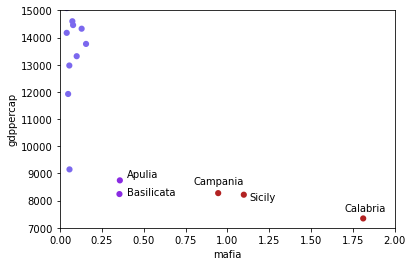

In [3]:
df1 = df[df['year'] >= 1983]
df2 = df1.groupby(['region', 'reg'])[['gdppercap', 'mafia', 'murd', 'ext', 'fire', 'kidnap', 'rob', 'smug',
            'drug', 'theft', 'orgcrime']].mean()
df2 = df2.reset_index()
# Figure 2.1
color = np.where((df2['reg']==15) | (df2['reg']==18) | (df2['reg']==19), 'firebrick',                # EXCLUDED
                 np.where((df2['reg']==16) | (df2['reg']==17), 'blueviolet',                         # TREATED
                          np.where((df2['reg']<=12) | (df2['reg']==20), 'mediumslateblue', 'none'))) # THE REST
df2.plot.scatter('mafia', 'gdppercap', c=color, s=10, linewidth=3, 
                 xlabel='Presence of mafia organisations',
                 ylabel='GDP per capita')
plt.annotate('Sicily', (1.097555, 8217.568359), xytext=(1.13, 8000))
plt.annotate('Calabria', (1.810759, 7344.603516), xytext=(1.7, 7600))
plt.annotate('Campania',(0.944485, 8275.800781), xytext=(0.8, 8600))
plt.annotate('Basilicata',(0.354640, 8241.510742), xytext=(0.4,8200))
plt.annotate('Apulia',(0.357075, 8745.296875), xytext=(0.4, 8850))
plt.ylim(7000,15000)
plt.xlim(0,2)

plt.savefig('Figure 2.1 Mafia-type Criminal Organisations and GDP Per Capita Across Italian Regions, Average Over the Period 1983–2007.jpg', dpi=300)

The fall from grace of Apulia and Basilicata coincided with the spread of mafia organizations into their territory, thus rendering worthwhile the analysis of a causal link between the two events. 
  Pinotti (2015) contributes to the literature on the growth stunting effects of organised crime with an analysis of the post-war economic development of the two regions in Italy, Apulia and Basilicata, which were exposed to mafia activity after the 1970s. 
  The peculiarity of these regions starts from their performance in terms of growth indicators over the years. In fact, Apulia and Basilicata were characterized by levels of criminal activity and economic growth akin to those of other Southern regions unaffected by mafia activity before the spread of criminal organizations. 

Things took a turn in the 1970s, following two pivotal changes. 
  First, the closure of the port of Tangier in 1960 caused a shift in the trade routes of tobacco smugglers, which suddenly involved the Adriatic regions. This change would represent a decisive factor for mafia involvement a decade later, when tobacco smuggling became the most profitable criminal business in Italy. Nowadays, tobacco smuggling has lost its podium position to large-scale nacotrafficking along the same routes. <br>
  Second, a strong earthquake hit in Basilicata in 1980, affecting the entire region and the neighboring regions of Campania and Apulia. Following the natural disaster, government relief and public investment flooded the regions, and in turn mafia appropriated as much as possible through embezzlement, intimidation and corruption of local authorities. <br>
   Besides pivotal events such as the ones detailed above, another measure helped the creation of networks and influence in the previously unaffected regions: *confino*. The initial intent of the provision was to break up links between mafiosi through the physical separation of the clans' upper echelons by confining them to far away regions, however, not only did the measure fail, but in the end it unintentionally aided the transplantation of these organizations into new territories.

## 2.1 Methodology
The two watershed events allow for a subdivision of the Italian regions into treated, control and excluded:


| Status    | Regions                                          |
| :---      | :---                                             |
| Treatment | Apulia, Basilicata                               |
| Control   | Abruzzo, Molise, Sardinia & Centre-North regions |
| Excluded  | Sicily, Campania, Calabria                       |

Excluded regions are Italian regions with a historical presence of mafia organizations, which are neither good for the control group nor as additional treatment units.

The units in the control group are weighted to build a synthetic control group which mimics the pre 1970s conditions in the treatment group and is used as a counterfactual scenario. The idea is that the weights should reflect the structural parameters that, in absence of treatment, should not have varied for the treated. Therefore, the synthetic control group should reflect how Apulia and Basilicata would have evolved in the absence of mafia introduction by replicating the initial conditions and the growth potential of the regions of interest. <br>
The weighting procedure is also a good tool to reduce potential omitted variable bias. 

#### 2.1.1. Synthetic control method
Let $ y_t $ be an outcome of interest which depends on the presence of organised crime. Each region will have outcome $y^1$ if exposed to organised crime, and $y^0$ otherwise:

$$y_t = c_t y^1_t + (1-c_t) y^0_t$$

where $c_t$ is a binary indicator for the presence of organised crime in the region. We only observe one of the two potential outcomes in a given year, but the treatment effect is $\beta_t=y^1_t-y^0_t$.

Synthetic control allows to overcome this issue. The estimator will compare the actual outcome in the treatment group to a weighted average of the units in the control group.

$$\hat{\beta}_t = y_t \sum_{i\in t}{w_t y_{it}}$$

where $w_t$ are the weights associated to each region in the control group. But how to choose the weights? A natural response is to optimize the weights with the aim of minimizing the distance between the treatment and control group before the two pivotal events happen. The optimal vector of weights $W^*(V)$ minimizes the square distance between the two groups:

$$\left(
x-\sum_{i\in I}{w_i x_i^0}
\right) '
V
\left(
x-\sum_{i\in I}{w_i x_i^0}
\right)$$

where $x$ and $x^0_i$ is the $(K\times 1)$ vector of predictors and $V$ is the $(K\times K)$ diagonal matrix with non-negative entries measuring the relative importance of each predictor. <br>
Therefore, we choose $V$, the matrix of weights, with the aim of minimizing

$$\frac{1}{T^0} \sum_{i\in T^0} \left( y_t-\sum{w^*_i y_{it}} \right) ^2 \space \text{for} \space T^0\le T$$

The mean square error is minimized in the period 1951-1960.

#### 2.1.2. Variables
The dependent variable of interest is real GDP *per capita* at 1990 euro-equivalent prices, as a measure of economic growth. The independent variables are the main predictors of economic growth in the literature, such as initial level of GDP *per capita*, the investment rate, a human capital indicator, population density, value added share per sector.

In general, looking for a variable that accurately measures mafia pervasiveness is arduous. Mafia organisations carry out a number of illicit activities such as gambling, loan-sharking, narcotrafficking, extortion, private protection services, money laundering and much more. They exercise pervasive control over the territories where they are situated, creating strong networking connections and exploiting violence to maintain a hold on their surroundings and their complex activities. <br> 
In Italy, the presence of criminal organizations can be measured with the number of cases ex Art. 416-bis of the Penal Code ("associazione a delinquere di stampo mafioso") every 100,000 inhabitants, an article introduced in the 1980s specifically aimed at capturing the specific characteristics of mafia type criminal organizations. However, using this as a measurement can be particularly problematic because of the pervasiveness of under-reporting in the case of mafia related crimes plagued by a culture of silence, referred to as *omertà*, upheld by its members and imposed upon the social environments they inhabit. 

Figure 2.2 reports the murder rate per 100,000 inhabitants over the years 1956-2007. Using the number of homicides every 100,000 inhabitants provides a much better measure for the presence of mafia since these organisations often employ violent techniques to carry out their activity and murders are less subject to under reporting. <br>
The historically mafia plagued regions of Sicily, Calabria and Campania constitute the excluded group. The second group is composed of Apulia and Basilicata, the two regions exposed from the 1970s to mafia organisations. Finally there are two residual groups, one for the rest of the Southern regions (Abruzzo, Molise and Sardinia) and one for the Centre-North regions (Piedmont, Aosta Valley, Lombardy, Trentino Alto Adige, Veneto, Friuli Venezia Giulia, Liguria, Emilia Romagna, Tuscany, Umbria, Marche, Lazio). <br>
From 1975 onwards the regions of Apulia and Basilicata go from having a murder rate in line with the rest of the well performing regions -at times even lower- to experiencing spikes in murders that mirror the same trend of the historically mafia-plagued regions. These trends motivate the choice of focusing on the murder rate as an indicator of mafia presence that is more reliable than Art. 416-bis statistics.

#### Figure 2.2: Murder Rate Over Time Across Different Areas in Italy, Years 1956–2007

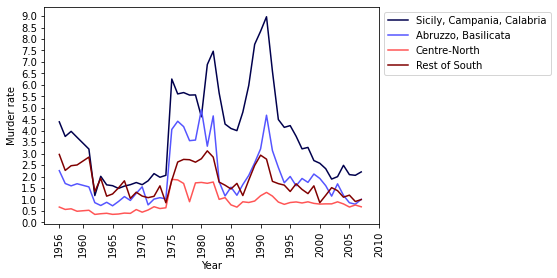

In [4]:
# filter to keep only the grouped data in the dataframe: NEW, HIS, STH, NTH
grouped = (df['reg'] > 20) & (df['reg'] <25)
# apply the filter to the dataframe and store it as df3
df3 = df.loc[grouped, ['murd', 'year', 'region']]
# only keep relevant years
df3 = df3[df3['year'] >= 1956]
df3 = df3[['murd', 'year', 'region']]
df3 = df3.pivot(index='year', 
                columns='region', 
                values='murd')
# rename df3 columns (can't change legend in graph below)
df3 = df3.rename(columns={'HIS':'Sicily, Campania, Calabria', 
                         'NEW':'Abruzzo, Basilicata', 
                        'NTH':'Centre-North', 
                        'STH':'Rest of South'})
# Figure 2.2
df3.plot(colormap='seismic', rot='vertical',
         xticks=[1956,1960,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010],
        yticks=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9],
        xlabel='Year', ylabel='Murder rate').legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig('Figure 2.2 Murder Rate Over Time Across Different Areas in Italy, Years 1955–2007.jpg', dpi=300)

## ***INSERT GEOPANDAS MAP ON ART 416-BIS AND MURDER RATE AVG?***

---
# 3. Synthetic control methods

- describe the methods we will use from econometric POV
- refer to Abadie paper
- insert methodological description
- paragraph on how to do it with python

Synthetic Controls are, “arguably the most important innovation in the policy evaluation literature in the last 15 years” - Athey and Imbens, 2017.


### What are they? (was in section 1)
- Used to evaluate the effect of an intervention in comparative case studies.
- Based on the idea that a combination of unaffected units often provides a better comparison than any single unaffected unit alone.
- This combination is captured through weights calculated by optimization algorithms. 
- Similar to Diff-in-Diff method; in fact, according to Abadie et al. (2010) the synthetic control methods generalizes the Diff-in-Diff model by allowing the effect of unobserved confounders to vary over time.
- This advantage arises from a flexible factor representation of the potential outcomes of treated units.
- Wide usage: Academia, multilateral organizations, think tanks, business analytics units, governmental agencies, and consulting firms.

---
# 4. Preliminary work for replication

## 4.1 Figures and Graphs

In [5]:
df1 = df[df['year'] >= 1983]

df2 = df1.groupby(['region', 'reg'])[['gdppercap', 'mafia', 'murd', 'ext', 'fire', 'kidnap', 'rob', 'smug',
            'drug', 'theft', 'orgcrime']].mean()

df2 = df2.reset_index()

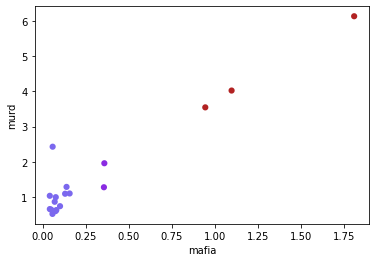

In [6]:
# Figure 3
df2.plot.scatter('mafia', 'murd', c=color, s=10, linewidth=3)
plt.rcParams["figure.figsize"] = (8,5)
plt.show()

## 4.2 Data Preparation

In [7]:
dtafile = 'dataset/Pinotti-replication/dataset.dta'
data = pd.read_stata(dtafile)

# Specify conditions for treated unit and control units as per Pinotti's paper (c.f. F216), 

treat_unit = data[data.reg == 21]
treat_unit = treat_unit[treat_unit.year <= 1960]                 # Matching period: 1951 to 1960
treat_unit_all = data[data.reg == 21]                            # Entire period:   1951 to 2007

control_units = data[(data.reg <= 14) | (data.reg ==20)]
control_units     = control_units[control_units.year <= 1960]
control_units_all = data[(data.reg <= 14) | (data.reg ==20)]

# Extract the outcome variable for treatment and control unit, y: GDP per capita

y_treat     = np.array(treat_unit.gdppercap).reshape(1, 10)              # Matching period 
y_treat_all = np.array(treat_unit_all.gdppercap).reshape(1, 57)          # Entire period

y_control     = np.array(control_units.gdppercap).reshape(15, 10)
y_control_all = np.array(control_units_all.gdppercap).reshape(15, 57)

Z1 = y_treat.T
Z0 = y_control.T

#### Data Organization into Appropriate Format 

In [8]:
## Prepare matrices with only the relevant variables into CVXPY format, predictors k = 8
predictor_variables = ['gdppercap', 'invrate', 'shvain', 'shvaag', 'shvams', 'shvanms', 'shskill', 'density']
X = data.loc[data['year'].isin(list(range(1951, 1961)))]
X.index = X.loc[:,'reg']

# k x 1 vector: mean values of k predictors for 1 treated unit
X0 = X.loc[(X.index <= 14) | (X.index ==20),(predictor_variables)] 
X0 = X0.groupby(X0.index).mean().values.T

# k x J matrix: mean values of k predictors for J untreated units
X1 = X.loc[(X.index == 21),(predictor_variables)]
X1 = X1.groupby(X1.index).mean().values.T

---
# 5. Replication of Pinotti (2015)

## 5.1 Optimization Objective for the Syntetic Control Method

##### A Simplfied Problem

$$
\hat{\boldsymbol{W}}=\operatorname{argmin}_{\boldsymbol{W}}\left[\sum_{m=1}^{k}\left(x_{m1}-\sum_{j=2}^{J+1}\boldsymbol{w}_{j} \boldsymbol{x}_{mj}\right)^{2}\right]
$$

subject to
                                                      
$$ \sum_{j=2}^{J+1}\boldsymbol{w}_{j}=1$$   

where $w$ are the 15 weights, one for each of the control regions that together form the 'donor pool'.

Here we make a simplifying assumption that the predictor matrix $V$ is just a diagonal matrix of 1's. That is, each predictor is given equal importance in the calculation of the weights. Which combination of weights best resembles the pre-intervention predictors values for the treated unit?


In [23]:
# Setup the function to call CVXPY and output a vector of weights function

def w_optimize(v=None):
    
    V = np.zeros(shape=(8, 8))
    
    if v is None:
        np.fill_diagonal(V, np.ones(8))
    
    else:
        np.fill_diagonal(V, v)

    W = cvx.Variable((15, 1), nonneg=True)
    objective_function    = cvx.Minimize(cvx.sum(V @ cvx.square(X1 - X0 @ W)))
    objective_constraints = [cvx.sum(W) == 1]
    objective_solution    = cvx.Problem(objective_function, objective_constraints).solve(verbose=False)
    
    return (W.value,objective_solution)

In [24]:
# CVXPY Solution
w_basic, objective_solution = w_optimize()
print('\nObjective Value: ',objective_solution,'\n\nOptimal Weights: ',w_basic.T)
solution_frame_1 = pd.DataFrame({'Region':control_units.region.unique(), 
                           'Weights': np.round(w_basic.T[0], decimals=3)})

display(solution_frame_1)


Objective Value:  833.2880036755997 

Optimal Weights:  [[0.         0.         0.         0.         0.15165999 0.
  0.         0.         0.         0.         0.         0.
  0.         0.84834001 0.        ]]


,Region,Weights
0,PIE,0.000
1,VDA,0.000
2,LOM,0.000
3,TAA,0.000
4,VEN,0.152
5,FVG,0.000
6,LIG,0.000
7,EMR,0.000
8,TOS,0.000
9,UMB,0.000


#### Commentary:
- The CVXPY minimization problem allocates weights to VEN (Veneto: 0.152) and MOL (Molise: 0.848). 
- In comparison the weights in the paper are to ABR (Abruzzo: 0.624) and MOL (0.376).
- Becker and Klößner found the weights to ABR (43.035), MOL 48.934, and Sardinia (SDR: 8.03045). (This is the 'correct' solution vector due to its RMSPE minimizing property.)

But what do these weights mean in terms of the actual performance of our synthetic controls?

## 5.2 Synthetic Control Performance Analysis

#### Graphical Comparison

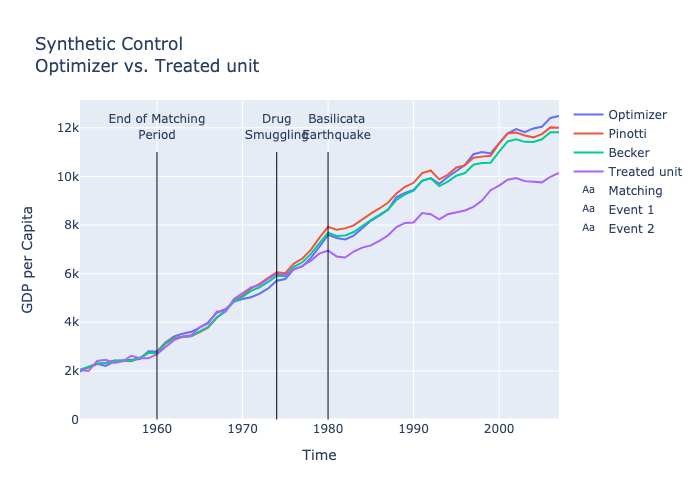

In [26]:
w_pinotti = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.624, 0.376, 0]).reshape(15, 1)
w_becker = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.43035, 0.48934, 0.0803045]).reshape(15,1)

y_synth_pinotti = w_pinotti.T @ y_control_all
y_synth_becker = w_becker.T @ y_control_all
y_synth_basic = w_basic.T @ y_control_all

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=y_synth_basic[0],
                    mode='lines', name='Optimizer'))
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=y_synth_pinotti[0],
                    mode='lines', name='Pinotti'))
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=y_synth_becker[0],
                    mode='lines', name='Becker'))
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=y_treat_all[0],
                    mode='lines', name='Treated unit'))

fig.add_shape(dict(type="line", x0=1960, y0=0, x1=1960, y1=11000,
                   line=dict(color="Black", width=1)))

fig.add_shape(dict(type="line", x0=1974, y0=0, x1=1974, y1=11000,
                   line=dict(color="Black", width=1)))

fig.add_shape(dict(type="line", x0=1980, y0=0, x1=1980, y1=11000,
                   line=dict(color="Black", width=1)))

fig.add_trace(go.Scatter(x=[1960], y=[12000], mode="text",
    name="Matching", text=["End of Matching<br>Period"]))

fig.add_trace(go.Scatter(x=[1974], y=[12000], mode="text",
    name="Event 1", text=["Drug<br>Smuggling"]))

fig.add_trace(go.Scatter(x=[1981], y=[12000], mode="text",
    name="Event 2", text=["Basilicata<br>Earthquake"]))

fig.update_layout(title='Synthetic Control<br>Optimizer vs. Treated unit',
                   xaxis_title='Time', yaxis_title='GDP per Capita')

# Dynamic graph
fig.show()

# Static graph only for display on github
#fig.show(renderer="png")

#### Table Comparison

In [12]:
# Function to obtain Root Mean Squared Prediction Error 
def RMSPE(w):
    return np.sqrt(np.mean((w.T @ y_control - y_treat)**2))

In [27]:
# Dataframe to show predicted vs actual values of variables and the RMSPE's.

x_pred_pinotti = (X0 @ w_pinotti)
x_pred_basic = (X0 @ w_basic)

pred_error_pinotti = x_pred_pinotti - X1
pred_error_basic = x_pred_basic - X1

y_pred_pinotti = w_pinotti.T @ y_control
y_pred_basic = w_basic.T @ y_control

data_compare = pd.DataFrame({'Actual':X1.T[0],
                             'Paper':x_pred_pinotti.T[0],
                             'Optimizer':x_pred_basic.T[0],
                             'Paper Differential': pred_error_pinotti.T[0],
                             'Optimizer Differential': pred_error_basic.T[0]},
                              index= data.columns[[3,16,11,12,13,14,26,28]]
)

print ('\nBreakdown across predictors:')

display(data_compare)

print('\nRMSPE CVXPY: {} \nRMSPE Paper: {} \nRMSPE Becker: {}'\
      .format(RMSPE(w_basic),RMSPE(w_pinotti),RMSPE(w_becker)))



Breakdown across predictors:


,Actual,Paper,Optimizer,Paper Differential,Optimizer Differential
gdppercap,2394.995605,2402.903783,2398.078601,7.908178,3.082995
invrate,0.316296,0.232005,0.212794,-0.084291,-0.103502
shvain,0.215479,0.221464,0.228207,0.005985,0.012728
shvaag,0.151702,0.154425,0.167108,0.002723,0.015406
shvams,0.401665,0.391364,0.383643,-0.010302,-0.018023
shvanms,0.231154,0.232748,0.221043,0.001594,-0.010111
shskill,0.165486,0.180807,0.159343,0.015321,-0.006143
density,134.778870,105.627378,106.077449,-29.151492,-28.701421



RMSPE CVXPY: 154.26663518337438 
RMSPE Paper: 130.14101997364745 
RMSPE Becker: 128.94693242022998


Our obtained weights $w$ can not be optimal since there exists weights $w^{*}$ such that 

[1] $$RMSPE(w) > RMSPE(w^{*})$$

Clearly, there is room for improvement in the optimization algorithm. Assuming equal predictor importance simplifies the problem to single variable optimization, but at the cost of reliability of the result. Therefore, we proceed by augmenting the objective function with the relative importance of each of the k (8) predictors.

### 5.3 Optimization with addition of relative importance of each of the k predictors: A Reformulated Problem

#### The choice of $V$ matters
To account for the heterogeneity in the effect of the 8 predictor variables on the outcomes Y (GDP per capita in Pinotti's case), Abadie and Gardeazabal (2003) proposed augmenting the optimization objective with a (k × k) diagonal matrix V, such that the diagonal elements are weights indicating the relative importance of each of the predictors. The problem becomes,

[3] $$W=\min \left(X_{1}-X_{0} W\right)' V\left(X_{1}-X_{0} W\right)$$ 

[4] $$V=\min \left[\left(Z_{1}-Z_{0} W^{*}(V))'\left(Z_{1}-Z_{0} W^{*}(V)\right]\right.\right.$$

So the diagonal elements themselves becomes part of the optimization steps in the calulcation of the synthetic controls. Moreover, they are subject to their own constraints, namely, that $V$ is a subset of all positive semi-definite diagonal matrices, such that the diagonal elements sum to one:

$$V \in\left\{\operatorname{diag}(V): V \in \mathbb{R}^{K \times K}, \sum_{k=1}^{K} V_{k k}=1, V_{k k} \geq 0\right\}=: \mathcal{V}$$

The move away from the equal weights assumption from the previous section increases the task complexity considerably. As Pekka Malo et al. remark, "A closer examination of the SCM problem ... reveals that the SCM problem is far from trivial from the computational point of view." (Pekka Malo et al., 2020:4).

To explore this complexity, we consider two approaches. First, by iterating over the solution set and, second, by comparing it to a nested optimization algorithm. 

#### Approach 1: Iterating over the solution set by generating $V$ from a Dirichlet distribution 

To reduce the complexity of bileval optimization, we proceed by continously drawing the diagonal elements of $V$ from the Dirichlet distribution (to satsify that the predictors weight must sum to 1), then note the convergence of the RMSPE of the minimization problem of [1] by iterating over this set of possible solutions using CVXPY and scipy.minimize.

##### CVXPY Implementation

In [14]:
n = 100000      # Number of iterations
iteration_2 = []

for i in range(n):
    
    v_diag  = np.random.dirichlet(np.ones(8), size=1)
    w_cvxpy = w_optimize(v_diag)[0]
    
    prediction_error =  RMSPE(w_cvxpy)    
    iteration_2.append([prediction_error, v_diag, w_cvxpy.T])


In [15]:
solution_frame_2 = pd.DataFrame(iteration_2)
solution_frame_2.columns =['Error', 'Relative Importance', 'Weights']

solution_frame_2 = solution_frame_2.sort_values(by='Error', ascending=True)
#solution_frame_2.head(10)

w_cvxpy = solution_frame_2.iloc[0][2][0]
v_cvxpy = solution_frame_2.iloc[0][1][0]

best_weights_region = pd.DataFrame({'Region':control_units.region.unique(), 
                                    'W(V*)': np.round(w_cvxpy, decimals=3)})

best_weights_importance = pd.DataFrame({'Predictors': data.columns[[3,16,11,12,13,14,26,28]],
                                        'V*': np.round(v_cvxpy, 3)})

#display(best_weights_importance)
display(best_weights_region)

,Region,W(V*)
0,PIE,0.000
1,VDA,0.000
2,LOM,0.000
3,TAA,0.000
4,VEN,0.000
5,FVG,0.000
6,LIG,0.000
7,EMR,0.000
8,TOS,0.000
9,UMB,0.000


In [31]:
y_synth_cvxpy = w_cvxpy.T @ y_control_all
y_pred_cvxpy = w_cvxpy.T @ y_control_all

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=y_synth_cvxpy,
                    mode='lines', name='Optimizer'))
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=y_synth_pinotti[0],
                    mode='lines', name='Pinotti'))
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=y_treat_all[0],
                    mode='lines', name='Treated unit'))
fig.add_shape(dict(type="line", x0=1960, y0=0, x1=1960, y1=11000,
                   line=dict(color="Black", width=1)))

fig.add_trace(go.Scatter(x=[1960], y=[12000], mode="text",
    name="Matching", text=["End of Matching<br>Period"]))

fig.update_layout(title='Synthetic Control<br>Optimizer vs. Treated unit',
                   xaxis_title='Time', yaxis_title='GDP per Capita')
fig.show()

print('\nRMSPE CVXPY w/o V*:  {} \nRMSPE CVXPY with V*: {} \nRMSPE from Paper:    {}'\
      .format(RMSPE(w_basic),RMSPE(w_cvxpy),RMSPE(w_pinotti)))

# Static graph only for display on github
#fig.show(renderer="png")


RMSPE CVXPY w/o V*:  154.26663518337438 
RMSPE CVXPY with V*: 130.41702456827844 
RMSPE from Paper:    130.14101997364745


#### Scipy Implementation 

In [52]:
n = 100000      # Number of iterations
A = X0
b = X1.ravel()
iteration_3 = []
init_w = [0]*15

bnds = ((0, 1),)*15

cons = ({'type': 'eq', 'fun': lambda x: 1.0 -  np.sum(x) })

def fmin(x,A,b,v):
    c = np.dot(A, x) - b
    d = c ** 2
    y = np.multiply(v,d)
    return np.sum(y)

for i in range(n):
    
    v = np.random.dirichlet(np.ones(8), size=1).T
    args = (A,b,v)
    
    res = optimize.minimize(fmin,init_w,args,method='SLSQP',bounds=bnds,
                            constraints=cons,tol=1e-10,options={'disp': False})
    
    
    prediction_error =  RMSPE(res.x)  
    iteration_3.append([prediction_error, v, res.x])

In [53]:
solution_frame_3 = pd.DataFrame(iteration_3)
solution_frame_3.columns =['Error', 'Relative Importance', 'Weights']

solution_frame_3 = solution_frame_3.sort_values(by='Error', ascending=True)

w_scipy = solution_frame_3.iloc[0][2]
v_scipy = solution_frame_3.iloc[0][1].T[0]

best_weights_region2 = pd.DataFrame({'Region':control_units.region.unique(), 
                                    'W(V*)': np.round(w_scipy, decimals=3)})

best_weights_importance2 = pd.DataFrame({'Predictors': data.columns[[3,16,11,12,13,14,26,28]],
                                        'V*': np.round(v_scipy, 3)})

#display(best_weights_importance2)
display(best_weights_region2)

y_synth_scipy = w_scipy.T @ y_control_all
y_pred_scipy = w_scipy.T @ y_control_all

print('\nRMSPE CVXPY w/o V*: {} \nRMSPE CVXPY: {} \nRMSPE scipy: {} \nRMSPE Paper: {}'\
      .format(RMSPE(w_basic),RMSPE(w_cvxpy),RMSPE(w_scipy),RMSPE(w_pinotti)))

,Region,W(V*)
0,PIE,0.000
1,VDA,0.000
2,LOM,0.000
3,TAA,0.000
4,VEN,0.000
5,FVG,0.000
6,LIG,0.000
7,EMR,0.000
8,TOS,0.000
9,UMB,0.000



RMSPE CVXPY w/o V*: 154.26663518337438 
RMSPE CVXPY: 130.41702456827844 
RMSPE scipy: 130.3197763854872 
RMSPE Paper: 130.14101997364745


Commentary:
(INSERT graphs of RMSPE and variance)
- Both methods approach the RMSPE minimal value but they do not provide the solution so the weights can not be optimal. This is evident because the optimality condition in Equation 4 still holds. 
- Furthermore, iterating over the solution set is, ultimately, a time consuming and unreliable method due to the variance of the results. 
- This deficiency calls for a faster and more reliable way of approaching the problem.

The response paper by Martin and Klößner (2017) to Pinotti's results remains the benchmark for this analysis. They are able to compare RMSPE-minimizing solution vectors (vector of weights of donor pool) across a battery of software implmentations (STATA, MATLAB, R/Synth, R/MSCMT) by maintaining parity in terms of Pinotti's dataset and and his specificaion of that data. 

They find that different software implementations produce slightly different results, but the one that produces the RMSPE minimizing set of weights is from their R/MSCMT package. Consequently, they conclude that the loss in GDP per capita due to the presence of the Mafia in the affected regions had been overestimated by Pinotti (16% instead of 18% in the original paper).

Although the response paper itself does not detail the optimization procedure of R/MSCMT, the generalized SCM paper by Martin and Klößner (2018) reveals several algorithms that can be used to solve the SCM problem. In particular, the one used in their response paper relies upon nested optimization: they use a combination of outer optimization via Differential Evolution and inner optimization via DWNNLS. (Weighted Non-negative least squares). This corresponds to the default option 'DEoptC' in the call to R/MSCMT's solver function in the R-code of their response paper's replication kit.

The Fortran implemenation of the WNNLS algorithm was presented by Hanson and Haskell (1982), and was later adapted to R language in the package limSolve (Martin and Klößner, 2017:14). WNNLS is a reliable and fast inner optimizer for the nested optimization problem of SCM, and, interestingly, which the authors of R/MSCMT enhance with a further speed boost by using Fortran-calls to WNNLS in a C-implementation (Martin and Klößner, 2017:18).


#### Approach 2: Nested Optimization: Combination of outer optimization ($W^*(V)$) via Differential Evolution and inner optimization $(W)$ via CVXPY convex minimization.

Differential Evolution for the outer optimization is available via the scipy optimize library, however WNNLS currently does not have an implementation in Python. Therefore, instead of approaching the inner optimization as a problem of solving linearly constrained least squares, we instead use linearly constrained convex minimization via CVXPY.

In [19]:
# Outer Optimization via Differential Evolution
def v_optimize(i):
    
    bounds  = [(0,1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]
    nlc     = NonlinearConstraint(constr_f, 1, 1, constr_jac, constr_hess)
    result  = differential_evolution(vmin, bounds, constraints=(nlc),seed=i)
    v_estim = result.x.reshape(8,1)  
    return (v_estim)

# Inner Optimization via CVXPY Constrained Convex Minimization
def w_optimize(v):

    W = cvx.Variable((15, 1), nonneg=True)
    objective_function    = cvx.Minimize(cvx.sum(cvx.multiply(v, cvx.square(X1 - X0 @ W))))
    objective_constraints = [cvx.sum(W) == 1]
    objective_solution    = cvx.Problem(objective_function, objective_constraints).solve(verbose=False)
    return (W.value)

# Objective Function of Differential Evolution in the Outer Optimization
def vmin(v):

    v = abs(v.reshape(8,1))
    W = w_optimize(v)
    return float((Z1 - Z0 @ W).T @ (Z1 - Z0 @ W))

## Additional Optimiality constraints
# Predictor weights MUST sum to one
def constr_f(v):
    return float(np.sum(v))

# Setting Hessian of V to zero due to linearity of approximated function in vmin
def constr_hess(x,v):
    return np.zeros([8,8])

# Additionally set Jacobian, (since differential_evolution requires either setting both Jacobian and Hessian
# manually or neither of them?)
def constr_jac(v):
    return np.ones(8)

In [20]:
n = 3
iteration_4 = []

for i in range(n):
    
    v_estim1 = v_optimize(i)
    w_estim1 = w_optimize(v_estim1)
    error = RMSPE(w_estim1)
    
    iteration_4.append([error,v_estim1,w_estim1])

/Users/DanialSyed/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.



In [21]:
solution_frame_4 = pd.DataFrame(iteration_4)
solution_frame_4.columns =['Error', 'Relative Importance', 'Weights']

solution_frame_4 = solution_frame_4.sort_values(by='Error', ascending=True)

w_nested = solution_frame_4.iloc[0][2]
v_nested = solution_frame_4.iloc[0][1].T[0]

display(solution_frame_4)

print('\nRMSPE scipy:     {} \nRMSPE CVXPY:     {} \nRMSPE Nested:    {} \nRMSPE Paper:     {} \nRMSPE Becker: {}'\
      .format(RMSPE(w_scipy),RMSPE(w_cvxpy),RMSPE(w_nested), RMSPE(w_pinotti), RMSPE(w_becker) ))

,Error,Relative Importance,Weights
1,130.140950,"[[1.3178636736566025e-05], [0.6050903047367413...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
2,154.028132,"[[0.4666250320275147], [0.04509185710687341], ...","[[0.0], [0.0], [0.0], [0.0], [0.14899425761859..."
0,154.028606,"[[0.2277511347723319], [0.055470769765426975],...","[[0.0], [0.0], [0.0], [0.0], [0.14900043950064..."



RMSPE scipy:     130.1743768154252 
RMSPE CVXPY:     130.41702456827844 
RMSPE Nested:    130.14095045540628 
RMSPE Paper:     130.14101997364745 
RMSPE Benchmark: 128.94693242022998


# 6. Conclusions

# N. References
- Pinotti, Paolo. *The economic consequences of organized crime: Evidence from Southern Italy.* Bank of Italy (2011).


- Becker, Martin, and Stefan Klößner. *Estimating the economic costs of organized crime by synthetic control methods.* Journal of Applied Econometrics 32.7 (2017): 1367-1369.


- Blackburn, Keith, Kyriakos C. Neanidis, and Maria Paola Rana. *A theory of organized crime, corruption and economic growth.* Economic Theory Bulletin 5.2 (2017): 227-245.


- Garoupa, Nuno. *The economics of organized crime and optimal law enforcement.* Economic Inquiry 38.2 (2000): 278-288.

